## Assignment 8A
In this assignment, you will practice working with random number generators and their applications to physical simulations. You are required to use the *recommended random number generators* discussed in class, as outlined in the lecture notes. Always use a seed, to ensure reproducibility.

### Problem 1 (20 points)
a) Write a program that generates and prints out two random numbers between 1 and 6, to simulate the rolling of two dices.

b) Modify your program to simulate rolling two dice one million times. Count how often a double six appears, then divide this count by one million to obtain the fraction of double sixes. You should get something close to, though probably not exactly equal to $\tfrac{1}{36}$.

In [27]:
# Imports
import numpy as np

# Part A
print(f"Random Dice Roll: {np.random.randint(1, 6+1)}, {np.random.randint(1, 6+1)}")

# Part B
COUNT = 1_000_000
rolls = np.random.randint(1, 6+1, size=(COUNT, 2))
double_six = [1 for roll in rolls if roll[0] == 6 and roll[1] == 6]
double_six = sum(double_six)
print(f"Total Double Sixes: {double_six} ({COUNT*1/36})")
print(f"Prop  Double Sixes: {double_six/COUNT} ({1/36})")

Random Dice Roll: 1, 3
Total Double Sixes: 27645 (27777.777777777777)
Prop  Double Sixes: 0.027645 (0.027777777777777776)


### Problem 2 (40 points)
This problem extends the simple radioactive decay simulation covered in the class notes. The isotope $^{213}\text{Bi}$ decays to stable $^{209}\text{Bi}$ via one of two different routes, with probabilities and half-lives thus:
$$\begin{align}
^{213}\text{Bi}&\xrightarrow[97.91\%]{\tau=46\text{ min}}\ ^{209}\text{Pb}\\
^{213}\text{Bi}&\xrightarrow[2.09\%]{\tau=46\text{ min}}\ ^{209}\text{Tl}\\
^{209}\text{Tl}&\xrightarrow[]{\tau=2.2\text{ min}}\ ^{209}\text{Pb}\\
^{209}\text{Pb}&\xrightarrow[]{\tau=3.3\text{ min}}\ ^{209}\text{Bi}\\
\end{align}$$
(Technically, $^{209}\text{Bi}$ is not truly stable, but with a half-life exceeding $10^{19}$ years—over a billion times the age of the universe—it is effectively stable for practical purposes.)

Starting with a sample consisting of 10,000 atoms of $^{213}\text{Bi}$, simulate the decay of the atoms as shown in the example problem in notes by dividing time into slices of length $\delta t = 1\text{s}$ each and on each step doing the following:


#### Problem 2.A
For each atom of $^{209}\text{Pb}$ in turn, decide at random, with the appropriate probability, whether it decays or not. The probability is given in the class notes:
$$P(t)=1-2^{-t/\tau}$$
Count the total number that decay, subtract it from the number of $^{209}\text{Pb}$ atoms, and add it to the number of $^{209}\text{Bi}$ atoms.

#### Problem 2.B
Now do the same for $^{209}\text{Tl}$, except that decaying atoms are subtracted from the total for $^{209}\text{Tl}$ and added to the total for $^{209}\text{Pb}$.

#### Problem 2.C
For $^{213}\text{Bi}$, the situation is more complicated: when a $^{213}\text{Bi}$ atom decays, you have to decide at random with the appropriate probability the route by which it decays. Count the numbers that decay by each route and add and subtract accordingly.

Running simulation for 50.0 minutes.
Bi213: 10000, Tl209: 0, Pb209: 0, Bi209: 0
Bi213: 6960, Tl209: 6, Pb209: 581, Bi209: 2453
Bi213: 4870, Tl209: 7, Pb209: 394, Bi209: 4729
Bi213: 3382, Tl209: 2, Pb209: 272, Bi209: 6344


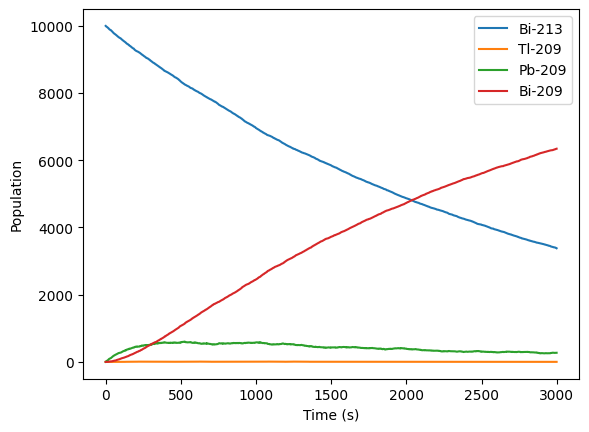

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters



# Random Choice Maker function


# Classes for the Isotopes
class Isotope:
    def __init__(self, population: int, half_life_seconds: float) -> None:
        self.population: int = population
        self.half_life_seconds: float = half_life_seconds

    def __add__(self, other: "Isotope") -> "Isotope":
        if type(self) == type(other):
            return type(self)(self.population + other.population)
        else:
            raise ValueError("Cannot add different types of isotopes.")
        
    def __iadd__(self, other: "Isotope") -> "Isotope":
        if type(self) == type(other):
            self.population += other.population
            return self
        else:
            raise ValueError("Cannot add different types of isotopes.")

    def __repr__(self):
        return f"{type(self).__name__}({self.population})"

    def _decay_population(self, Δt: float) -> int:

        # Calculate the decay quantities
        decay_probability: float = 1 - np.exp(-Δt/self.half_life_seconds)
        decay_population: int = sum([1 for _ in range(self.population) if np.random.rand() < decay_probability])

        # Update the population and return the decayed population
        self.population -= decay_population
        return decay_population
    
    def decay(self, Δt: float) -> int:
        raise NotImplementedError("Subclasses must implement the decay method.")

class Bismuth213(Isotope):
    def __init__(self, population: int):
        super().__init__(population, half_life_seconds=46*60)
    
    def decay(self, Δt: float) -> tuple[Isotope, Isotope]:
        decay_population: int = self._decay_population(Δt)
        new_Tl209 = 0
        new_Pb209 = 0
        for _ in range(decay_population):
            if np.random.rand() < 0.9791:  # Probability to decay to Pb209
                new_Pb209 += 1
            else:                          # Probability to decay to Tl209
                new_Tl209 += 1
        return (Thallium209(new_Tl209), Lead209(new_Pb209))
        
class Thallium209(Isotope):
    def __init__(self, population: int):
        super().__init__(population, half_life_seconds=2.2*60)

    def decay(self, Δt: float) -> tuple[Isotope, Isotope]:
        decay_population: int = self._decay_population(Δt)
        return Lead209(decay_population)

class Lead209(Isotope):
    def __init__(self, population: int):
        super().__init__(population, half_life_seconds=3.3*60)

    def decay(self, Δt: float) -> tuple[Isotope, Isotope]:
        decay_population: int = self._decay_population(Δt)
        return Bismuth209(decay_population)

class Bismuth209(Isotope):
    def __init__(self, population: int):
        super().__init__(population, half_life_seconds=float("inf"))

    def decay(self, Δt: float) -> tuple[Isotope, Isotope]:
        raise NotImplementedError("Bismuth-209 cannot decay.")


# Initial Populations
POPULATION_BI213: int = 10_000  # Initial Bi-213 Population
Δt: float = 1.0                 # 1 second time step
Bi213: Isotope = Bismuth213(POPULATION_BI213)
Tl209: Isotope = Thallium209(0)
Pb209: Isotope = Lead209(0)
Bi209: Isotope = Bismuth209(0)

# Run the simulation
TIME = 25_000
PLOT_RESULTS = True  # This shit is SLOWWWWWWW
BI213_DECAY_CHAIN = True
TL209_DECAY_CHAIN = True
PB209_DECAY_CHAIN = True
if PLOT_RESULTS:
    Bi213_list = []
    Tl209_list = []
    Pb209_list = []
    Bi209_list = []

print(f"Running simulation for {TIME/60:.1f} minutes.")
for _ in range(TIME):

    # Print the populations
    if _ % 1_000 == 0:
        print(f"Bi213: {Bi213.population}, Tl209: {Tl209.population}, Pb209: {Pb209.population}, Bi209: {Bi209.population}")

    # Bisuth-213 Decay
    if BI213_DECAY_CHAIN and Bi213.population != 0:
        new_Tl209, new_Pb209 = Bi213.decay(Δt)  # Removes decayed population
        Tl209 += new_Tl209                      # Adds new Thallium-209 population
        Pb209 += new_Pb209                      # Adds new Lead-209 population

    # Thallium-209 Decay
    if TL209_DECAY_CHAIN and Tl209.population != 0:
        new_Pb209 = Tl209.decay(Δt)  # Removes decayed population
        Pb209 += new_Pb209           # Adds new Lead-209 population

    # Lead-209 Decay
    if PB209_DECAY_CHAIN and Pb209.population != 0:
        new_Bi209 = Pb209.decay(Δt)  # Removes decayed population
        Bi209 += new_Bi209           # Adds new Bismuth-209 population

    # If plot, plot the results
    if PLOT_RESULTS:
        Bi213_list.append(Bi213.population)
        Tl209_list.append(Tl209.population)
        Pb209_list.append(Pb209.population)
        Bi209_list.append(Bi209.population)
    
    # Assert population is conserved
    assert (POPULATION_BI213 == Bi213.population + Tl209.population + Pb209.population + Bi209.population)
    
# Print the final populations
print(f"Bi213: {Bi213.population}, Tl209: {Tl209.population}, Pb209: {Pb209.population}, Bi209: {Bi209.population}")
if PLOT_RESULTS:
    plt.plot(Bi213_list, label="Bi-213")
    plt.plot(Tl209_list, label="Tl-209")
    plt.plot(Pb209_list, label="Pb-209")
    plt.plot(Bi209_list, label="Bi-209")
    plt.xlabel("Time (s)")
    plt.ylabel("Population")
    plt.legend()
    plt.show

### Problem 3 (40 points)